In [44]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
#!pip install tabulate
from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
import pandas as pd
import re
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from IPython.display import display
from tabulate import tabulate

# 基于「生存分析」的新用户转化分析

In [2]:
df = pd.read_excel('./data/user_buy.xlsx')
df.head()

,user_id,signup_time,end_time,test_last_time,buy_time,sex,birth_year,province,have_bought
0,513336,2017-10-30 21:58:04.323,2017-10-30 22:03:54.430,2018-06-01,2017-10-30 22:03:54.430,女,1991.0,山东,True
1,513340,2017-10-30 22:14:35.853,2017-10-30 22:45:10.243,2018-06-01,2017-10-30 22:45:10.243,男,1988.0,安徽,True
2,513353,2017-10-31 07:29:04.293,2018-06-01 00:00:00.000,2018-06-01,NaT,NaN,NaN,NaN,False
3,513370,2017-10-31 10:45:45.586,2018-06-01 00:00:00.000,2018-06-01,NaT,女,1979.0,河南,False
4,513387,2017-10-31 13:00:32.360,2017-10-31 13:09:38.100,2018-06-01,2017-10-31 13:09:38.100,女,1992.0,山东,True


In [49]:
#print(tabulate(df.head(), headers=df.columns, tablefmt="pipe"))

In [3]:
df.describe(include='all')

,user_id,signup_time,end_time,test_last_time,buy_time,sex,birth_year,province,have_bought
count,26563.000000,26563,26563,26563,11659,15217,13923.000000,15217,26563
unique,NaN,26563,11660,1,11659,2,NaN,31,2
top,NaN,2017-10-31 14:56:11.993000,2018-06-01 00:00:00,2018-06-01 00:00:00,2017-10-10 08:16:44.393000,女,NaN,浙江,False
freq,NaN,1,14904,26563,1,9691,NaN,1921,14904
first,NaN,2017-09-01 01:11:12.703000,2017-09-01 03:39:32.656000,2018-06-01 00:00:00,2017-09-01 03:39:32.656000,NaN,NaN,NaN,NaN
last,NaN,2018-05-31 23:43:44.243000,2018-06-01 00:00:00,2018-06-01 00:00:00,2018-05-31 23:56:19.263000,NaN,NaN,NaN,NaN
mean,519948.924820,NaN,NaN,NaN,NaN,NaN,1982.964950,NaN,NaN
std,7668.342368,NaN,NaN,NaN,NaN,NaN,11.346981,NaN,NaN
min,506667.000000,NaN,NaN,NaN,NaN,NaN,1931.000000,NaN,NaN
25%,513308.500000,NaN,NaN,NaN,NaN,NaN,1976.000000,NaN,NaN


In [4]:
df['duration'] = (df['end_time'] - df['signup_time']).apply(lambda x: x.total_seconds()/3600/24)

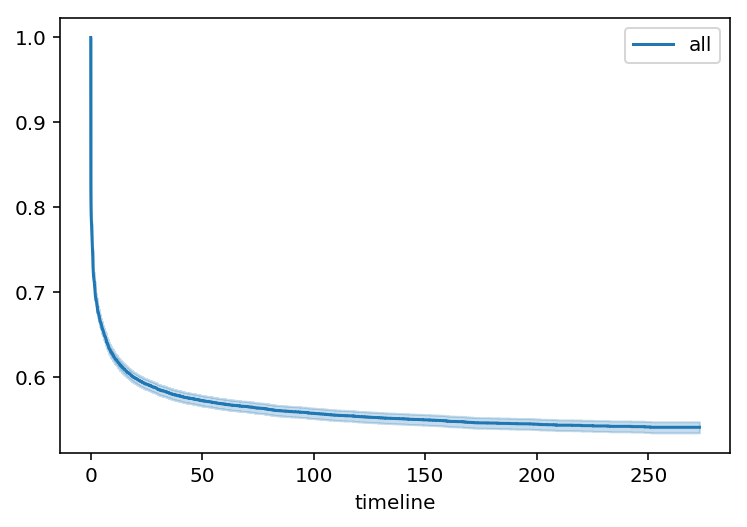

In [5]:
kmf = KaplanMeierFitter()
kmf.fit(df['duration'], event_observed=df['have_bought'], label='all')
kmf.plot()

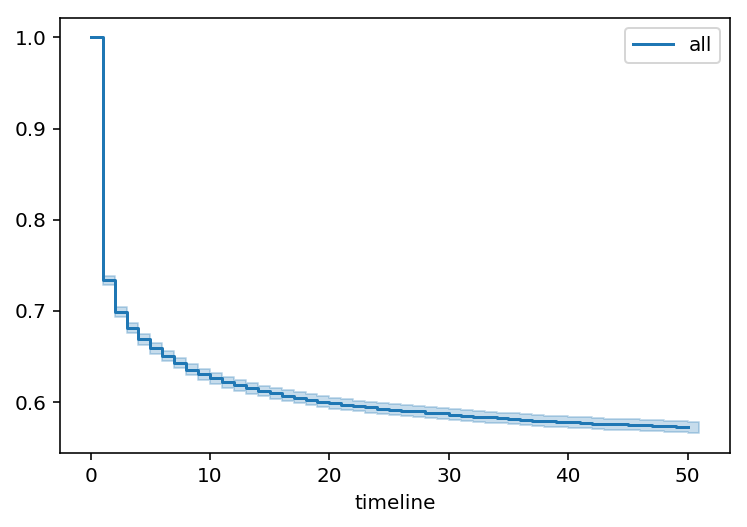

In [50]:
t = np.linspace(0, 50, 51)

kmf = KaplanMeierFitter()
kmf.fit(df['duration'], event_observed=df['have_bought'], label='all', timeline=t)
kmf.plot()

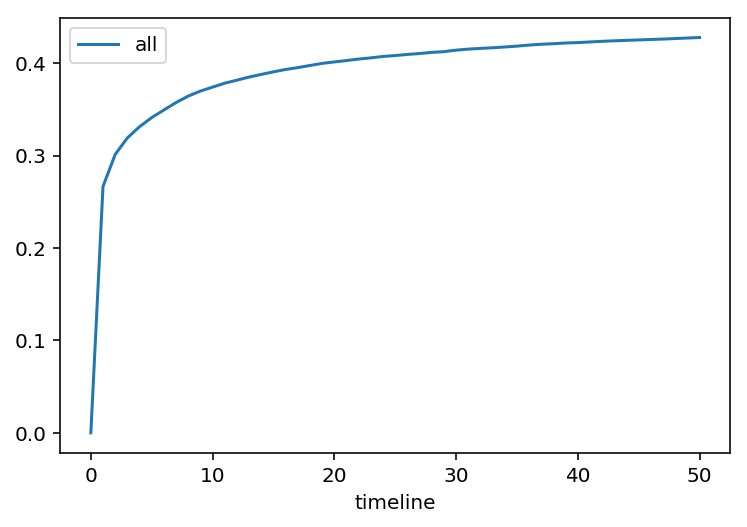

In [51]:
(1 - kmf.survival_function_).plot()

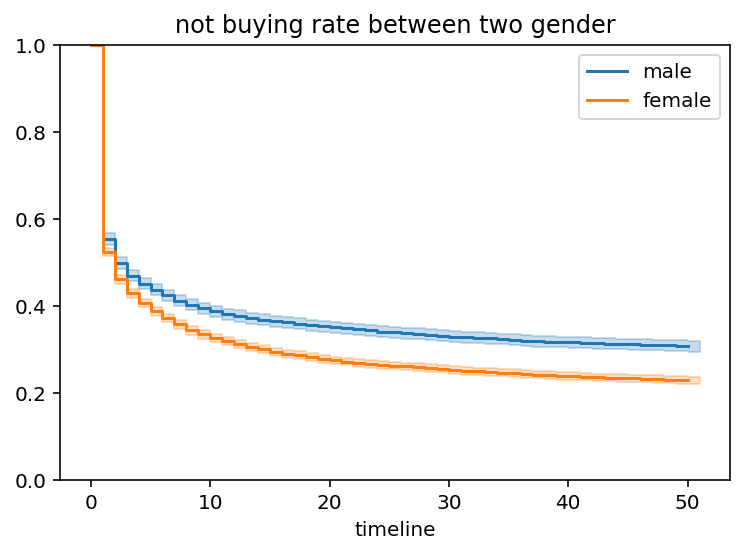

In [7]:
ax = subplot(111)

t = np.linspace(0, 50, 51)
kmf.fit(df[df['sex'] == '男']['duration'], event_observed=df[df['sex'] == '男']['have_bought'], timeline=t, label="male")
ax = kmf.plot(ax=ax)

kmf.fit(df[df['sex'] == '女']['duration'], event_observed=df[df['sex'] == '女']['have_bought'], timeline=t, label="female")
ax = kmf.plot(ax=ax)

plt.ylim(0,1)
plt.title("not buying rate between two gender");

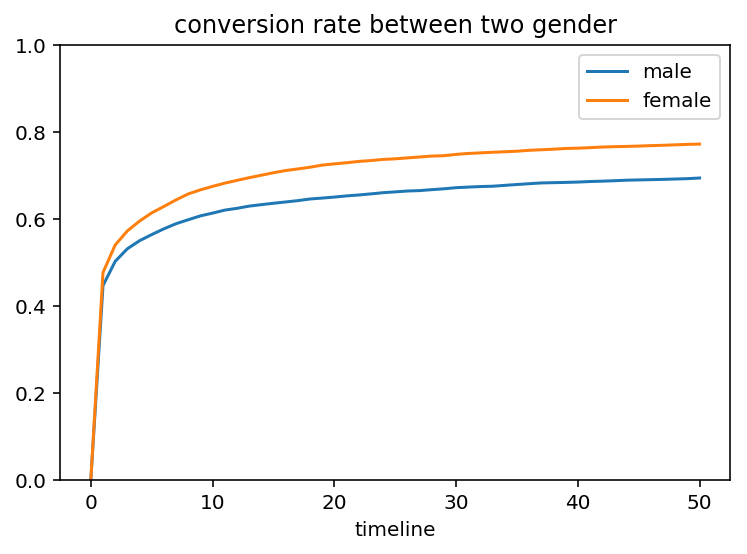

In [8]:
ax = subplot(111)

t = np.linspace(0, 50, 51)
kmf.fit(df[df['sex'] == '男']['duration'], event_observed=df[df['sex'] == '男']['have_bought'], timeline=t, label="male")
ax = (1 - kmf.survival_function_).plot(ax=ax)

kmf.fit(df[df['sex'] == '女']['duration'], event_observed=df[df['sex'] == '女']['have_bought'], timeline=t, label="female")
ax = (1 - kmf.survival_function_).plot(ax=ax)

plt.ylim(0,1)
plt.title("conversion rate between two gender");

In [9]:
logrank_test(event_times_A=df[df['sex']=='男']['duration'], event_observed_A=df[df['sex']=='男']['duration'],
            event_times_B=df[df['sex']=='女']['duration'], event_observed_B=df[df['sex']=='女']['duration'])

<lifelines.StatisticalResult: 

t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p     
       82.2898 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 
>

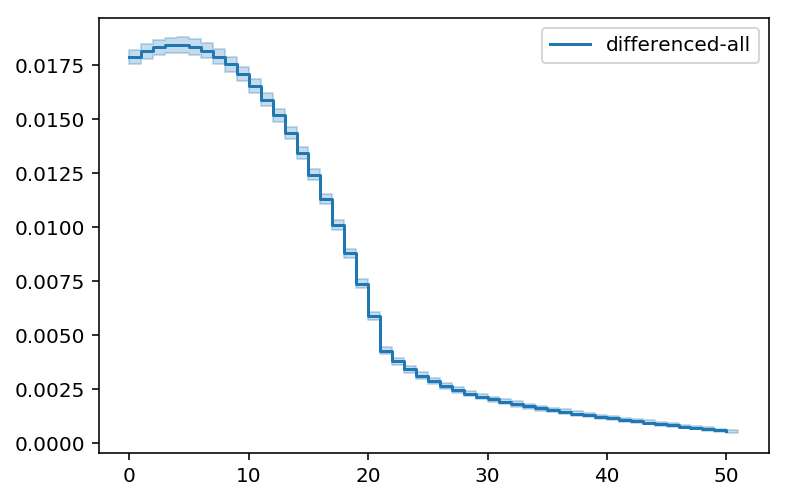

In [10]:
naf = NelsonAalenFitter()
naf.fit(df['duration'], event_observed=df['have_bought'], timeline=t, label='all')
naf.plot_hazard(bandwidth=20)

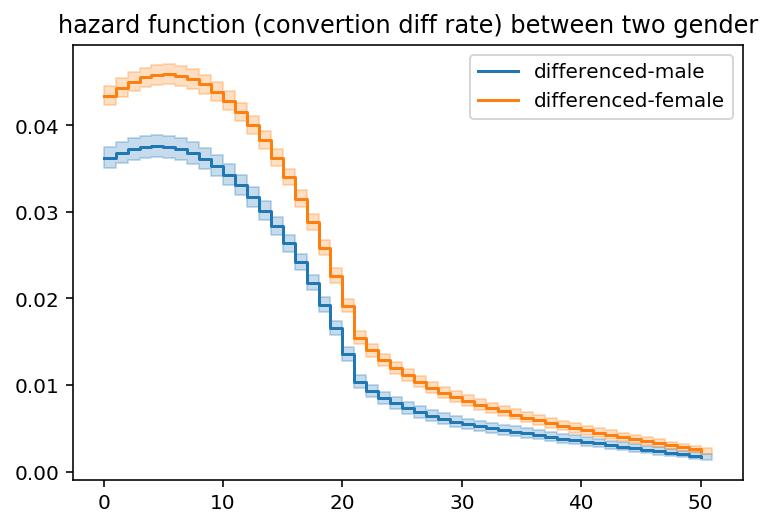

In [11]:
ax = subplot(111)

t = np.linspace(0, 50, 51)
naf.fit(df[df['sex'] == '男']['duration'], event_observed=df[df['sex'] == '男']['have_bought'], timeline=t, label="male")
ax = naf.plot_hazard(bandwidth=20, ax=ax)

naf.fit(df[df['sex'] == '女']['duration'], event_observed=df[df['sex'] == '女']['have_bought'], timeline=t, label="female")
ax = naf.plot_hazard(bandwidth=20, ax=ax)

plt.title("hazard function (convertion diff rate) between two gender");

In [58]:
cph_df = df[~pd.isnull(df['birth_year'])][['birth_year', 'duration', 'have_bought', 'sex']]
cph_df['sex'] = cph_df['sex'].apply(lambda x: 1 if x=='男' else 0)
cph_df['birth_year'] = cph_df['birth_year'] // 10 * 10
cph_df.shape

(13923, 4)

In [59]:
cph_df.head()

,birth_year,duration,have_bought,sex
0,1990.0,0.004052,True,0
1,1980.0,0.021231,True,1
3,1970.0,212.551556,False,0
4,1990.0,0.006316,True,0
6,1990.0,1.728810,True,1


In [60]:
cph_train_df, cph_test_df = cph_df.iloc[0:10000, :], cph_df.iloc[10000:, :]

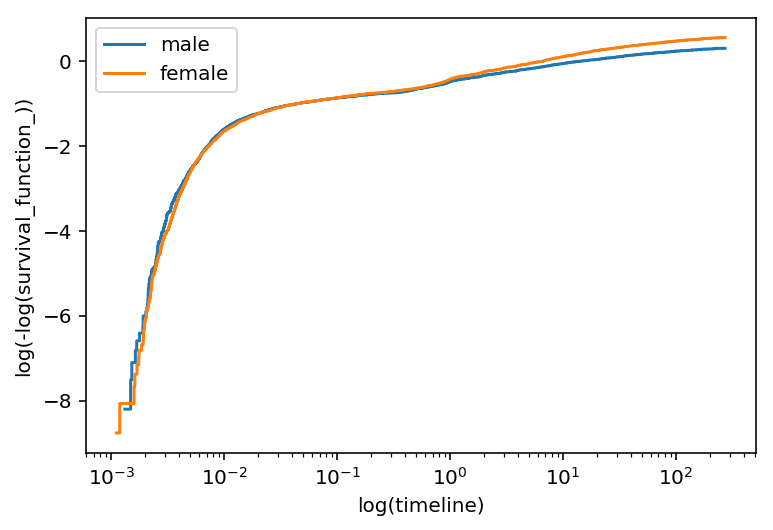

In [61]:
kmf0 = KaplanMeierFitter()
kmf0.fit(cph_train_df[cph_train_df['sex'] == 1]['duration'], event_observed=cph_train_df[cph_train_df['sex'] == 1]['have_bought'])

kmf1 = KaplanMeierFitter()
kmf1.fit(cph_train_df[cph_train_df['sex'] == 0]['duration'], event_observed=cph_train_df[cph_train_df['sex'] == 0]['have_bought'])

fig, axes = plt.subplots()
kmf0.plot_loglogs(ax=axes)
kmf1.plot_loglogs(ax=axes)

axes.legend(['male', 'female'])

plt.show()

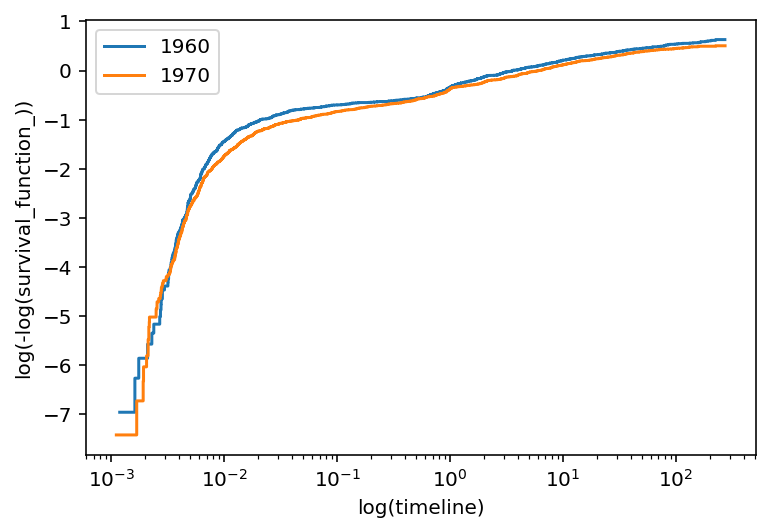

In [62]:
kmf0 = KaplanMeierFitter()
kmf0.fit(cph_train_df[((cph_train_df['birth_year'] >= 1960)&(cph_train_df['birth_year'] < 1970))]['duration'], 
         event_observed=cph_train_df[((cph_train_df['birth_year'] >= 1960)&(cph_train_df['birth_year'] < 1970))]['have_bought'])

kmf1 = KaplanMeierFitter()
kmf1.fit(cph_train_df[((cph_train_df['birth_year'] >= 1970)&(cph_train_df['birth_year'] < 1980))]['duration'], 
         event_observed=cph_train_df[((cph_train_df['birth_year'] >= 1970)&(cph_train_df['birth_year'] < 1980))]['have_bought'])

fig, axes = plt.subplots()
kmf0.plot_loglogs(ax=axes)
kmf1.plot_loglogs(ax=axes)

axes.legend(['1960', '1970'])

plt.show()

In [63]:
# need waiting for a long while
cph = CoxPHFitter()
cph.fit(cph_train_df, duration_col='duration', event_col='have_bought', show_progress=True)

Iteration 1: norm_delta = 0.12321, step_size = 0.95000, ll = -66208.90484, seconds_since_start = 2.7
Iteration 2: norm_delta = 0.00584, step_size = 0.95000, ll = -66146.60101, seconds_since_start = 5.0
Iteration 3: norm_delta = 0.00030, step_size = 0.95000, ll = -66146.45978, seconds_since_start = 7.4
Iteration 4: norm_delta = 0.00002, step_size = 0.95000, ll = -66146.45940, seconds_since_start = 9.6
Iteration 5: norm_delta = 0.00000, step_size = 0.95000, ll = -66146.45940, seconds_since_start = 11.5
Convergence completed after 5 iterations.


<lifelines.CoxPHFitter: fitted with 10000 observations, 2317 censored>

In [64]:
cph.print_summary()

n=10000, number of events=7683

              coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
birth_year -0.0084     0.9916    0.0010 -8.7945 0.0000     -0.0103     -0.0066  ***
sex        -0.1676     0.8457    0.0241 -6.9492 0.0000     -0.2149     -0.1203  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.528
Likelihood ratio test = 124.891 on 2 df, p=0.00000


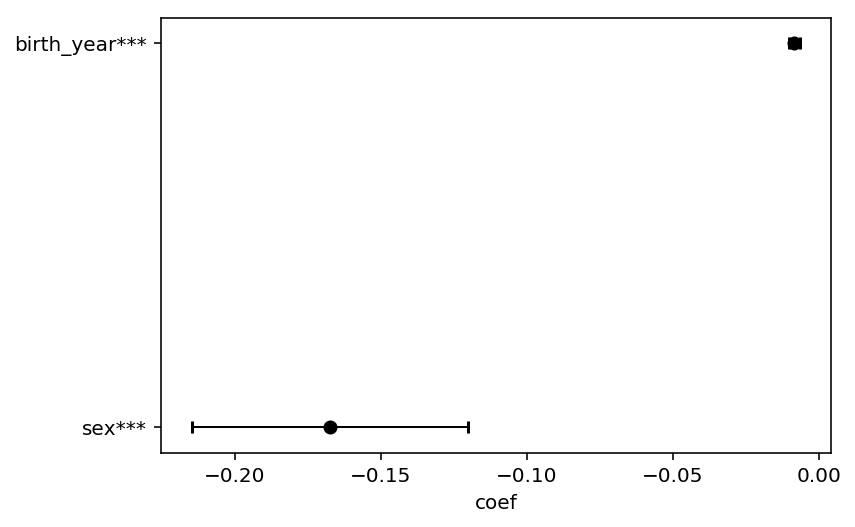

In [65]:
cph.plot()

/Users/tonyhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


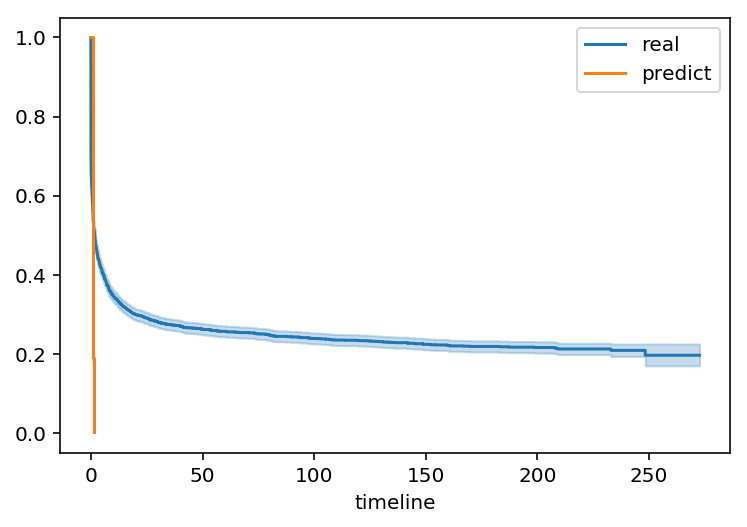

In [66]:
cph_test_df_predict = cph_test_df[['birth_year', 'sex']]
cph_test_df['predict_duration'] = cph.predict_partial_hazard(cph_test_df_predict)

kmf0 = KaplanMeierFitter()
kmf0.fit(cph_test_df['duration'], event_observed=cph_test_df['have_bought'])

kmf1 = KaplanMeierFitter()
kmf1.fit(cph_test_df['predict_duration'], event_observed=cph_test_df['have_bought'])

fig, axes = plt.subplots()
kmf0.plot(ax=axes)
kmf1.plot(ax=axes)

axes.legend(['real', 'predict'])

plt.show()

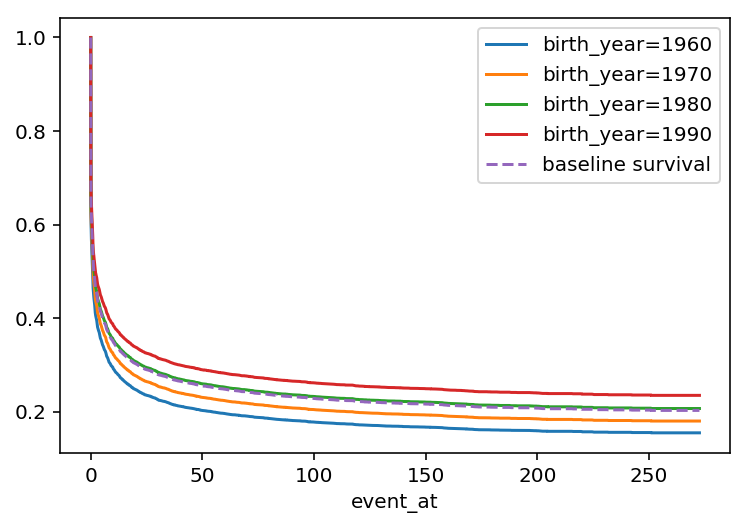

In [69]:
cph.plot_covariate_groups('birth_year', [1960, 1970, 1980, 1990])

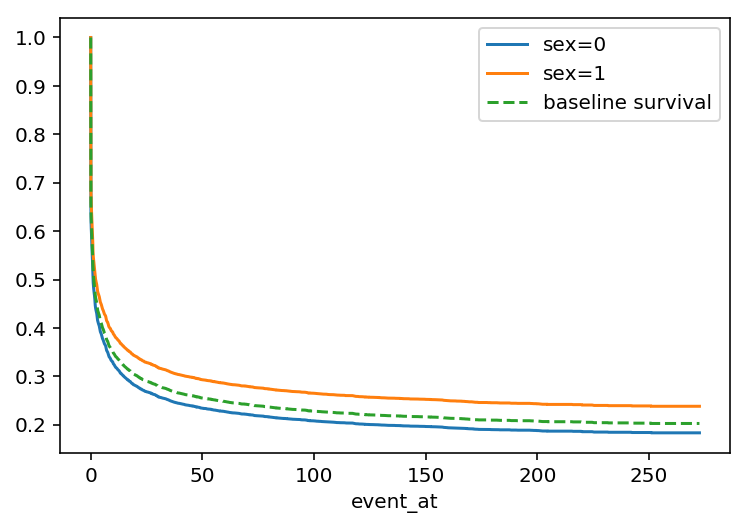

In [70]:
cph.plot_covariate_groups('sex', [0, 1])